# Energy vs Power cell example

In this exercise, we will compare a simple energy cell vs a power cell.

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

## 1. Create a simple simulation

First, create a simple simulation using the DFN model and the "Chen2020" parameter set and simulate a 1C discharge until 2.5V. 

In [2]:
model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues("Chen2020")
solver = pybamm.IDAKLUSolver()
experiment = pybamm.Experiment(["Discharge at 1C until 2.5V"])
sim = pybamm.Simulation(
    model, parameter_values=parameter_values, experiment=experiment, solver=solver
)
sol = sim.solve(initial_soc=1)

Plot the voltage vs time for this simulation.

Mean power:  18.25766877156833 W
Energy:  17.503454322656733 Wh


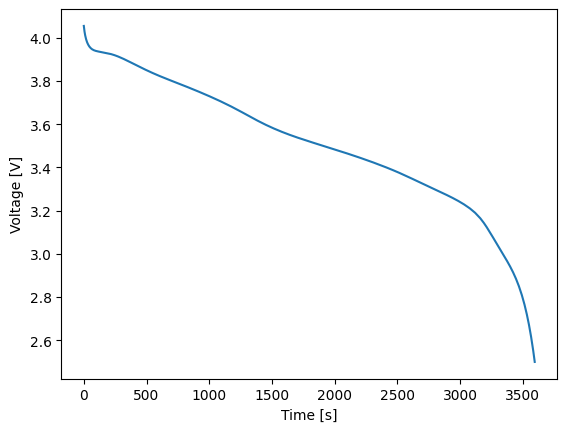

In [3]:
fig, ax = plt.subplots()
time = sol["Time [s]"].data
ax.plot(time, sol["Voltage [V]"].data)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Voltage [V]")

power = sol["Power [W]"].data
energy = np.trapz(power, time / 3600)

print("Mean power: ", np.mean(power), "W")
print("Energy: ", energy, "Wh")

Print the mean power and total energy for the 1C discharge (hint: use the "Power [W]" variable to extract the power, then use `np.trapz` to calculate the energy).

## 2. Sweep the C-rate

Now, run the same simulation for the following C-rates: [0.1, 0.2, 0.5, 1, 2, 3, 5, 10, 20]. For each run, store the mean power and total energy.

In [4]:
C_rates = [0.1, 0.2, 0.5, 1, 2, 3, 5, 10, 20]


def sweep_c_rate(C_rates, parameter_values):
    outputs = {"C-rate": C_rates, "Energy [Wh]": [], "Power [W]": []}
    for C_rate in C_rates:
        print(f"Sweeping C-rate {C_rate}C")
        experiment = pybamm.Experiment([f"Discharge at {C_rate}C until 2.5V"])
        sim = pybamm.Simulation(
            model,
            parameter_values=parameter_values,
            experiment=experiment,
            solver=solver,
        )
        sol = sim.solve(initial_soc=1)
        time = sol["Time [s]"].data
        power = sol["Power [W]"].data
        energy = np.trapz(power, time / 3600)
        outputs["Energy [Wh]"].append(energy)
        outputs["Power [W]"].append(np.mean(power))

    return outputs


outputs_energy_cell = sweep_c_rate(C_rates, parameter_values)

Sweeping C-rate 0.1C
Sweeping C-rate 0.2C
Sweeping C-rate 0.5C
Sweeping C-rate 1C
Sweeping C-rate 2C
Sweeping C-rate 3C
Sweeping C-rate 5C
Sweeping C-rate 10C
Sweeping C-rate 20C


Now plot the energy vs C-rate and the power vs C-rate for this cell.

Text(0.5, 0.98, 'Energy cell')

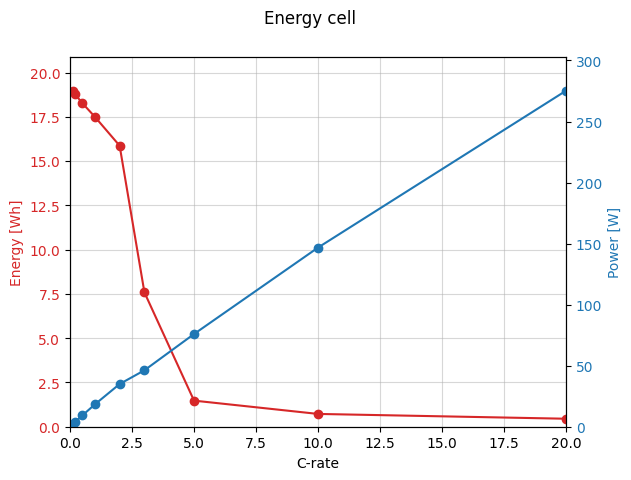

In [5]:
def plot_power_vs_energy(outputs):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_xlabel("C-rate")

    # change y axis labels and color to blue
    ax.plot(outputs["C-rate"], outputs["Energy [Wh]"], "-o", color="tab:red")
    ax.set_ylabel("Energy [Wh]", color="tab:red")
    ax.tick_params(axis="y", labelcolor="tab:red")
    ax.set_ylim(0, outputs["Energy [Wh]"][0] * 1.1)

    # add a twin axis for time on a log scale
    ax2.plot(outputs["C-rate"], outputs["Power [W]"], "-o", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylabel("Power [W]", color="tab:blue")
    ax2.set_xlim(0, outputs["C-rate"][-1])
    ax2.set_ylim(0, outputs["Power [W]"][-1] * 1.1)

    ax.grid(alpha=0.5)

    return fig, ax


fig, ax = plot_power_vs_energy(outputs_energy_cell)
fig.suptitle("Energy cell")

This is an energy cell with a maximum C-rate of 2C, so the energy should drop off significantly as the C-rate increases above 2C.


## 3. Change electrode thickness to simulate a power cell

To simulate a power cell, we can halve the thickness of the electrodes. Let's halve the thickness of both the positive electrode and the negative electrode proportionally to avoid having to change the N/P ratio and electrode balance.
To start with, create a new parameter set that is a copy of the "Chen2020" parameter set. Then, halve the thickness of the electrodes.
Hint: the parameters to change are "Negative electrode thickness [m]" and "Positive electrode thickness [m]". Also, halve the "Nominal cell capacity [A.h]" parameter so that the C-rate translates to the appropriate current for this new cell.

In [6]:
parameter_values_power_cell = pybamm.ParameterValues("Chen2020")
parameter_values_power_cell["Negative electrode thickness [m]"] *= 1 / 2
parameter_values_power_cell["Positive electrode thickness [m]"] *= 1 / 2
# Change the width of the electrodes so that the cell has the same volume as the energy cell
parameter_values_power_cell["Electrode width [m]"] *= 2

Now, sweep the C-rate for this new parameter set and plot the energy vs C-rate and the power vs C-rate for this cell. You can use the same code as in the previous section, either by going back and creating a function, or by copying and pasting the code.

Sweeping C-rate 0.1C
Sweeping C-rate 0.2C
Sweeping C-rate 0.5C
Sweeping C-rate 1C
Sweeping C-rate 2C
Sweeping C-rate 3C
Sweeping C-rate 5C
Sweeping C-rate 10C
Sweeping C-rate 20C


Text(0.5, 0.98, 'Power cell')

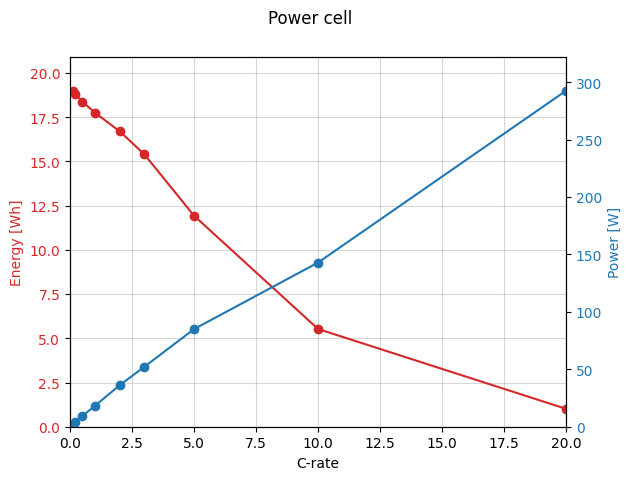

In [7]:
outputs_power_cell = sweep_c_rate(C_rates, parameter_values_power_cell)
fig, ax = plot_power_vs_energy(outputs_power_cell)
fig.suptitle("Power cell")

The power cell maintains its capacity better at higher C-rates. The downside of the power cell is that it has a lower specific energy since the ratio of active material to inactive material (current collector, separator, etc.) is higher. PyBaMM does not provide a specific energy / specific power, so you would need to define your own function for how cell mass depends on parameters to get specific energy and specific power.

Finally, plot energy and power vs C-rate for both the energy cell and the power cell on the same plot, normalized by the maximum energy and power for each cell.

Text(0.5, 0.98, 'Energy cell (o) vs Power cell (x)')

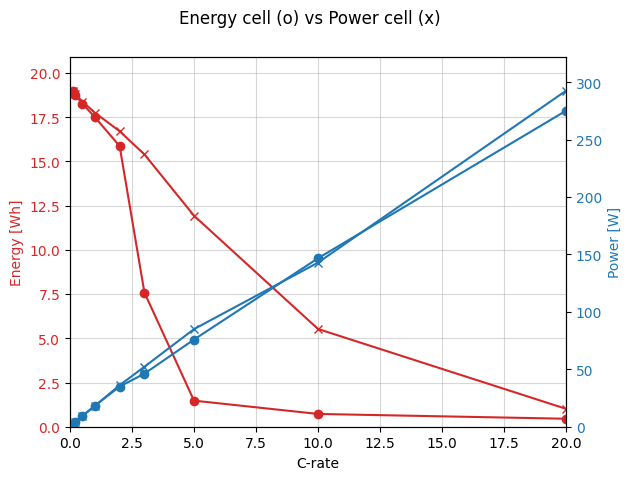

In [8]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.set_xlabel("C-rate")

styles = ["-o", "-x"]
for outputs, style in zip([outputs_energy_cell, outputs_power_cell], styles):
    # change y axis labels and color to blue
    ax.plot(
        outputs["C-rate"],
        outputs["Energy [Wh]"],
        style,
        color="tab:red",
    )
    ax.set_ylabel("Energy [Wh]", color="tab:red")
    ax.tick_params(axis="y", labelcolor="tab:red")
    ax.set_ylim(0, outputs["Energy [Wh]"][0] * 1.1)

    # add a twin axis for time on a log scale
    ax2.plot(
        outputs["C-rate"],
        outputs["Power [W]"],
        style,
        color="tab:blue",
    )
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylabel("Power [W]", color="tab:blue")
    ax2.set_xlim(0, outputs["C-rate"][-1])
    ax2.set_ylim(0, outputs["Power [W]"][-1] * 1.1)

ax.grid(alpha=0.5)
fig.suptitle("Energy cell (o) vs Power cell (x)")